# Load

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
from scipy import integrate

import matplotlib.pyplot as plt

In [3]:
import importlib
ch = importlib.import_module('control_helper')

In [11]:
ch = importlib.reload(ch)

# Dynamics

(in the repo, there is an accompanying mathematica notebook to help check these results)

Solve the Hamilton equations of motion for the state variable X of the cartpole system to find the 1st order equation of motion $\dot{X} = f(X,t)$:

\begin{align}
    \dot{x}        &= \frac{- ml \cos(\theta) p_\theta + ml^2 p_x }{d(\theta)} \\
    \dot{p_x}      &= 0 \\
    \dot{\theta}   &= \frac{ (M+m) p_\theta - ml \cos(\theta) p_x }{d(\theta)} \\
    \dot{p_\theta} &= - \frac{l^2 m p_x^2 d'(\theta )}{2 d(\theta )^2}-\frac{l m p_\theta p_x \cos (\theta ) d'(\theta )}{d(\theta )^2}+\frac{p_\theta^2 (m+M) d'(\theta )}{2 d(\theta )^2}-\frac{l m p_\theta p_x \sin (\theta )}{d(\theta )}+g l m \sin (\theta )
\end{align}

with 
$d(\theta) = ml^2 (M + m \sin^2(\theta) )$

Use ode45 to time-evolve the dynamical system, and make a movie of the result.

Comments:
- should I write everything in terms of mass ratios?
- need to go back and add friction
- choice of units?

In [33]:
# c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2, 'length_pole': .75})
c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2.1, 'length_pole': .75})

In [54]:
def make_movie(x,th):
    xmin,xmax = [min(x)-2*c.l, max(x)+2*c.l]
    ymin,ymax = [-2*c.l, 2*c.l]
    for i,t in enumerate(time):
        if i%10==0:
            fig, ax = plt.subplots(1)
            ax.set_xlim([xmin,xmax])
            ax.set_ylim([ymin,ymax])
            ax.set_aspect('equal')

            # Plot data
            cm_pole = [x[i]+c.l*np.sin(th[i]), c.l*np.cos(th[i])]
            ax.plot(x[:i]+c.l*np.sin(th[:i]), c.l*np.cos(th[:i]), ls='--', lw=1)
            cm_cart = [x[i], 0]
            ax.set_title(str(round(t, 2)), fontsize=20)
            ax.plot([cm_cart[0], 2*(cm_pole[0]-cm_cart[0])+cm_cart[0]], [cm_cart[1], 2*cm_pole[1]], c='k')
            ax.scatter(*cm_pole, marker='o', c='k')
            ax.scatter(*cm_cart, marker='s', s=500, c='k')
            ax.axis('off')

            plt.close() # prevent print
            ch.DisplayFigure(fig)

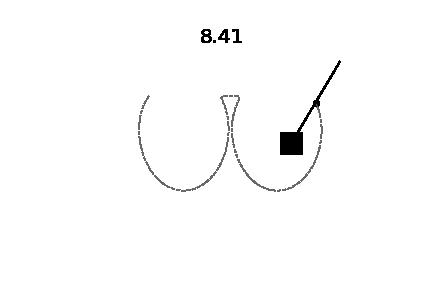

In [81]:
y0 = [0, 1, 0, 0]
tmin, tmax = [0,8.5]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
res = integrate.solve_ivp(c.rhs, [tmin, tmax], y0, t_eval=time)

x,px,th,pth = res.y
make_movie(x,th)

# Controllability

Find the fixed points of the dynamics. Then, compute the Jacobian and evaluate the result at the fixed points of 
$p_x \rightarrow 0, p_\theta \rightarrow 0, \theta \rightarrow 0, \pi$:

\[
    J = \left(
    \begin{array}{cccc}
     0 & \frac{1}{M} & 0 & s \frac{1}{l M} \\
     0 & 0 & 0 & 0 \\
     0 & s \frac{1}{l M} & 0 & \frac{m+M}{l^2 m M} \\
     0 & 0 & -s g l m + \frac{\text{p$\theta $}^2 (m+M)}{l^2 M^2} + s \frac{2 m \text{p$\theta $} \text{px}}{l M^2}+s \frac{\text{p$\theta $} \text{px}}{l M}+\frac{m \text{px}^2}{M^2} & 0 \\
    \end{array}
    \right)
\]

The variable $s$ holds the sign associated with $\pi \Rightarrow s=1$ and $0 \Rightarrow s=1$.

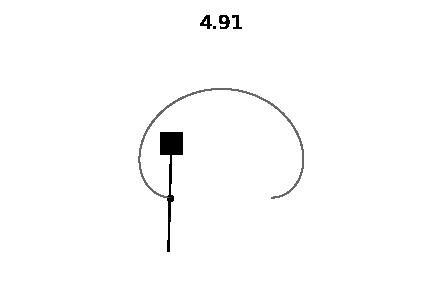

In [80]:
# Check for controllability by looking at the rank of the controllability matrix
# Look at the SVD and interpret

tmin, tmax = [0,5]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
                   
y0 = [0, 0, np.pi, 0]
linear_res = np.array([sp.linalg.expm(c.A(-1) * t)@y0 for t in time])
x,px,th,pth = linear_res.T
                   
make_movie(x,th)                  

In [2]:
# Check the behavior of placing eigenvalues deeper into the negative half-plane

In [ ]:
# Run the lqr for choice of Q and R to find the optimal regulator
# Look at the eigenvalues to learn what optimal control is doing
# Should see that xdot and thetadot are VERY controllable.

# Observability

In [ ]:
# Choose a sensor (let's say the position, x)
# Construct the observability matrix and check for observability
# Look at the SVD and interpret

In [ ]:
# Is there an observable subsystem? Omit x.